### Steps followed :

1) Considered a random graph whose max-cut is to be found.

2) Converted the problem into a Quadratic Program (QP), this can be done by converting into an Ising Hamiltonian and then into a Quadratic Program or directly. I did the latter. 

3) Solved the QP using CPLEX - obtained the optimal value and the optimal string.

4) Relaxed the QP to get a relaxation (Continuous variables), the solution of this continuous relaxation is different from the solution to the binary problem but can be used to warm-start a solver.

5) Solved the relaxed version using CobylaOptimizer i.e we obtained c* used to warm-start QAOA. **NOTE** - Didn't/Couldn't use CPLEX because the objective function is non-convex. And CobylaOptimizer supports both continuous variables and non-convex functions.

6) Solved the QP using standard QAOA.

#### Solving using WS-QAOA : 
7) Made the intial state from c*.

\begin{align}
|\phi^*\rangle=\bigotimes_{i=0}^{n-1}R_y(\theta_i)|0\rangle_n .
\end{align}

8) Made the WS-Mixer.

9) Solved the QP using WS-QAOA.

#### Observations and Analysis :

10) Both results (7 and 9) appear to give the same result. However, when we look at the underlying probability distribution we observe that WS-QAOA has a much higher probability of sampling the optimal solution.

In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA,COBYLA,SLSQP
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
import numpy as np
import copy

from qiskit_optimization.algorithms import CobylaOptimizer
# Problem modelling imports

from docplex.mp.model import Model

# Qiskit imports
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
import numpy as np
import copy
from time import time
# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo

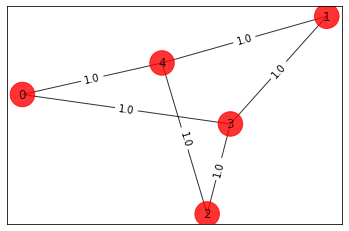

In [2]:
# Generating a graph of 4 nodes 

n=5 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,3,1.0),(0,4,1.0),(1,3,1.0),(1,4,1.0),(2,3,1.0),(2,4,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
draw_graph(G, colors, pos)

In [3]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0.]]


In [4]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qp.to_docplex().prettyprint()
#CplexOptimizer().solve(qp)
#qubitOp, offset = qp.to_ising()
#print('Offset:', offset)
#print('Ising Hamiltonian:')
#print(str(qubitOp))

// This file has been generated by DOcplex
// model name is: Max-cut
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;

maximize
 2 x_0 + 2 x_1 + 2 x_2 + 3 x_3 + 3 x_4 [ - 2 x_0*x_3 - 2 x_0*x_4 - 2 x_1*x_3
 - 2 x_1*x_4 - 2 x_2*x_3 - 2 x_2*x_4 ];
 
subject to {

}


In [5]:
def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem





#qubitOp, offset = qp.to_ising()
#print('Offset:', offset)
#print('Ising Hamiltonian:')
#print(str(qubitOp))

In [6]:
#from qiskit_optimization.converters import LinearEqualityToPenalty

In [7]:
#lineq2penalty = LinearEqualityToPenalty()
#qubo1 = lineq2penalty.convert(qp)
#print(qubo1.export_as_lp_string())

In [8]:
CplexOptimizer().solve(qp)

optimal function value: 6.0
optimal value: [1. 1. 1. 0. 0.]
status: SUCCESS

In [9]:
qp1 = relax_problem(QuadraticProgramToQubo().convert(qp))
qp1
#exact1 = MinimumEigenOptimizer(NumPyMinimumEigensolver())
#result1 = exact1.solve(qp1)
#print(result1)
optimizer = CobylaOptimizer()
result = optimizer.solve(qp1) 
result

optimal function value: 6.0
optimal value: [1. 1. 1. 0. 0.]
status: SUCCESS

In [10]:
c_stars = result.samples[0].x
c_stars

array([1., 1., 1., 0., 0.])

In [138]:
t0=time()
algorithm_globals.random_seed = 12345
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                   seed_simulator=algorithm_globals.random_seed,
                                   seed_transpiler=algorithm_globals.random_seed)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.,2.,4.,1.2,0.9,0.5,0.6,1.,2.],reps=5)
exact_mes = NumPyMinimumEigensolver()


In [139]:
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [140]:
qaoa_result = qaoa.solve(qp)
print(qaoa_result)
time() - t0

optimal function value: 6.0
optimal value: [1. 1. 1. 0. 0.]
status: SUCCESS


7.622608184814453

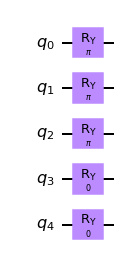

In [141]:
from qiskit import QuantumCircuit

thetas = [2*np.arcsin(np.sqrt(c_star)) for c_star in c_stars]

init_qc = QuantumCircuit((n))
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)
    
init_qc.draw(output='mpl')

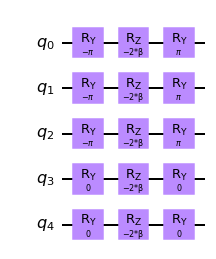

In [142]:
from qiskit.circuit import Parameter

beta = Parameter('β')

ws_mixer = QuantumCircuit(n)
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2*beta, idx)
    ws_mixer.ry(theta, idx)
    
ws_mixer.draw(output='mpl')

In [143]:
t0=time()
ws_qaoa_mes = QAOA(quantum_instance=quantum_instance, 
                   initial_state=init_qc, 
                   mixer=ws_mixer,
                   initial_point=[0., 1.,2.,4.],reps=2)



In [144]:
ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)

In [145]:
ws_qaoa_result = ws_qaoa.solve(qp)
print(ws_qaoa_result)
time()-t0

optimal function value: 6.0
optimal value: [1. 1. 1. 0. 0.]
status: SUCCESS


0.20644712448120117

In [146]:
qc1=ws_qaoa_mes.get_optimal_circuit()

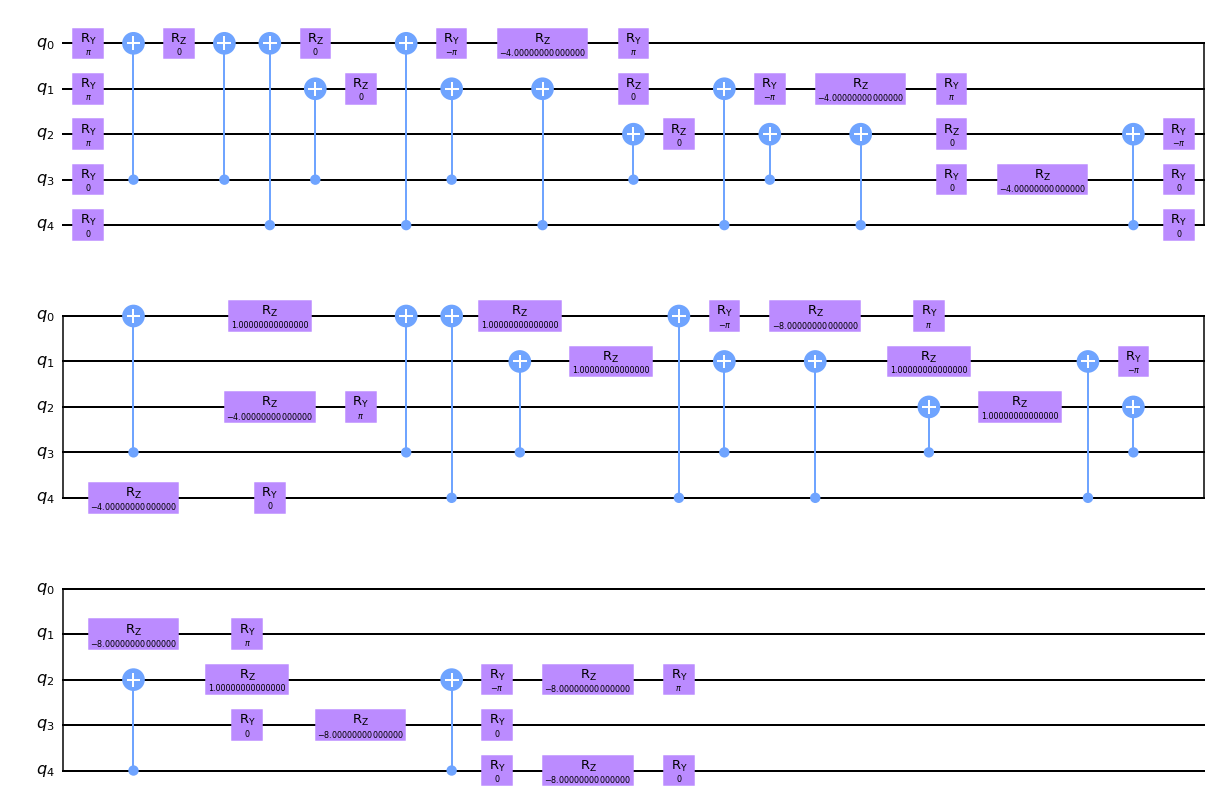

In [147]:
qc1.draw(output='mpl')

### Advantage of WS-QAOA over Standard QAOA

The underlying probability distribution depicts that WS-QAOA has a much higher probability of sampling the optimal solution.

In [148]:
def format_qaoa_samples(samples, max_len: int = 10):
    qaoa_res = []
    for s in samples:
        if sum(s.x) == 2:
            qaoa_res.append((''.join([str(int(_)) for _ in s.x]), s.fval, s.probability))
        if sum(s.x) == 3:
            qaoa_res.append((''.join([str(int(_)) for _ in s.x]), s.fval, s.probability))
        if sum(s.x) == 4:
            qaoa_res.append((''.join([str(int(_)) for _ in s.x]), s.fval, s.probability))  
        if sum(s.x) == 5:
            qaoa_res.append((''.join([str(int(_)) for _ in s.x]), s.fval, s.probability))    
    res = sorted(qaoa_res, key=lambda x: -x[1])[0:max_len]
            
    return [(_[0] + f': value: {_[1]:.3f}, probability: {1e2*_[2]:.1f}%') for _ in res]

format_qaoa_samples(qaoa_result.samples)

ws_qaoa_result.raw_samples

[SolutionSample(x=array([1, 1, 1, 0, 0]), fval=6.0, probability=1.0000000000000002, status=<OptimizationResultStatus.SUCCESS: 0>)]

In [149]:
format_qaoa_samples(qaoa_result.samples)

['11100: value: 6.000, probability: 50.0%',
 '00011: value: 6.000, probability: 50.0%']

In [66]:

from qiskit_optimization.algorithms import WarmStartQAOAOptimizer

In [67]:
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CobylaOptimizer(), relax_for_pre_solver=True, 
                                 qaoa=qaoa_mes, epsilon=0.0)

In [68]:
ws_result = ws_qaoa.solve(qp)
ws_result

optimal function value: 6.0
optimal value: [1. 1. 1. 0. 0.]
status: SUCCESS

In [69]:
format_qaoa_samples(ws_result.samples)

['11100: value: 6.000, probability: 100.0%']